In [4]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed
import matplotlib as mpl

from numba import njit, prange

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [5]:
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

In [6]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [8]:
snap = np.arange(0, 1600, 20)

In [5]:
import glob
def read_pattern_speed(freq_path, name, lvl, snap):
    frq = h5.File(freq_path + '/freq_' + name + '-' + lvl + '/freq_' + name + '-' + lvl + '.' + \
             str(0)+'.hdf5', mode='r')
    ans = np.array(frq['PatternSpeed'][snap])
    frq.close()
    return ans

In [6]:
freq_path = '/n/home01/abeane/starbar/plots/freq/data'

ps_N = read_pattern_speed(freq_path, 'Nbody', 'lvl3', snap)
ps_S = read_pattern_speed(freq_path, 'phantom-vacuum-Sg20-Rc3.5', 'lvl3', snap) 

In [7]:
print(ps_N[25], ps_S[25])

36.28619541264606 40.61218678609953


In [2]:
import glob
def read_chunk(freq_path, name, lvl, i, snap):
    frq = h5.File(freq_path + '/freq_' + name + '-' + lvl + '/freq_' + name + '-' + lvl + '.' + \
             str(i)+'.hdf5', mode='r')
    ans1 = np.array(frq['PartType1/Frequencies'][:,snap,:])
    
    ans2 = np.array(frq['PartType1/Resonances'][:,snap,:])
    
    ans3 = np.array(frq['PartType1/DeltaLz'][snap,:])
    ans3 = np.swapaxes(ans3, 0, 1)
#     ans2 = np.swapaxes(ans2, 0, 1)
    
    ans = np.concatenate((ans1, ans2, ans3[:,:,np.newaxis]), axis=-1)
    frq.close()
    return ans

In [5]:
freq_path = '/n/home01/abeane/starbar/plots/freq/data'
name = 'Nbody'
lvl = 'lvl4'
i = 0
snap = np.array([300, 400, 500, 600])

ans = read_chunk(freq_path, name, lvl, i, snap)

# print(np.shape(ans1), np.shape(ans2), np.shape(ans3.reshape((1601, 4, 1))))
# print(np.shape(ans1), np.shape(ans2), np.shape(ans3))

# ans = np.concatenate((ans1, ans2, ans3[:,:,np.newaxis]), axis=-1)

In [10]:
freq_path = '/n/home01/abeane/starbar/plots/freq/data'

name = 'phantom-vacuum-Sg20-Rc3.5'
lvl='lvl4'

nchunk = len(glob.glob(freq_path + '/freq_' + name + '-' + lvl + '/freq_*'))
nproc = 48

# Omega_S = np.array([]).reshape((0, 3))
# snap = np.arange(0, 1600, 20)
print(nchunk)
# nchunk = 512

out = Parallel(n_jobs=nproc) (delayed(read_chunk)(freq_path, name, lvl, i, snap) for i in tqdm(range(nchunk)))
Omega_S3 = np.concatenate(out)

1024


A Jupyter Widget

In [11]:
# np.save('data/Omega_S3.npy', Omega_S3)
np.save('data/Omega_S4.npy', Omega_S3)

In [8]:
Omega_S3 = np.load('data/Omega_S3.npy')

In [9]:
freq_path = '/n/home01/abeane/starbar/plots/freq/data'

name = 'Nbody'
lvl='lvl4'

nchunk = len(glob.glob(freq_path + '/freq_' + name + '-' + lvl + '/freq_*'))
nproc = 48

# Omega_S = np.array([]).reshape((0, 3))
# snap = np.arange(0, 1600, 50)
print(nchunk)
# nchunk = 512

out = Parallel(n_jobs=nproc) (delayed(read_chunk)(freq_path, name, lvl, i, snap) for i in tqdm(range(nchunk)))
Omega_N4 = np.concatenate(out)

512


A Jupyter Widget

In [10]:
np.save('data/Omega_N4.npy', Omega_N4)

In [9]:
# Omega_N3 = np.load('data/Omega_N3.npy')

In [10]:
@njit
def RES_IDX(i, j, k, N):
    return i*N*N + j*N + k

@njit
def RES_IDX_2D(i, j, N):
    return i*N + j

In [11]:
@njit
def count_res(res, lRmin=-7, lRmax=7, lphimin=-7, lphimax=7, lzmin=-7, lzmax=7):
    lRlist = np.arange(lRmin, lRmax+1)
    lphilist = np.arange(lphimin, lphimax+1)
    lzlist = np.arange(lzmin, lzmax+1)
    
    Nres = len(lRlist)
    
    res_list = np.zeros((Nres**3, 3))
    
    for i in range(len(lRlist)):
        for j in range(len(lphilist)):
            for k in range(len(lzlist)):
                res_list[RES_IDX(i, j, k, Nres)][0] = lRlist[i]
                res_list[RES_IDX(i, j, k, Nres)][1] = lphilist[j]
                res_list[RES_IDX(i, j, k, Nres)][2] = lzlist[k]
    
    Npart = res.shape[0]
    Nsnap = res.shape[1]
    print(Npart, Nsnap)
    
    N_in_res = np.zeros((Nsnap, Nres**3))
    
    for j in range(Nsnap):
        for i in range(Npart):
            if res[i][j][0] == np.nan:
                continue
            
            # now check all reso

            ii = int(res[i][j][0] - lRmin)
            jj = int(res[i][j][1] - lphimin)
            kk = int(res[i][j][2] - lzmin)
            
            if ((ii==0 and jj==0) and kk==0):
                print(ii, jj, kk, i, j)
    
            N_in_res[j][RES_IDX(ii,jj,kk,Nres)] += 1
    
    return N_in_res, res_list

In [111]:
res = Omega_N4[:,:,3:]
print(res.shape)
%time N_in_res, res_list = count_res(res)

(3168480, 32, 3)
3168480 32
CPU times: user 7.14 s, sys: 10.5 ms, total: 7.15 s
Wall time: 7.15 s


In [114]:
N_in_res[4][np.flip(np.argsort(N_in_res[4]))][:100]

array([2.732074e+06, 4.401000e+03, 3.747000e+03, 2.964000e+03,
       2.919000e+03, 2.807000e+03, 2.773000e+03, 2.650000e+03,
       2.564000e+03, 2.475000e+03, 2.328000e+03, 2.277000e+03,
       2.243000e+03, 2.154000e+03, 2.047000e+03, 2.046000e+03,
       2.030000e+03, 2.015000e+03, 2.008000e+03, 1.932000e+03,
       1.880000e+03, 1.879000e+03, 1.858000e+03, 1.811000e+03,
       1.804000e+03, 1.801000e+03, 1.785000e+03, 1.782000e+03,
       1.767000e+03, 1.702000e+03, 1.688000e+03, 1.680000e+03,
       1.678000e+03, 1.674000e+03, 1.650000e+03, 1.635000e+03,
       1.619000e+03, 1.612000e+03, 1.593000e+03, 1.573000e+03,
       1.571000e+03, 1.568000e+03, 1.513000e+03, 1.462000e+03,
       1.442000e+03, 1.432000e+03, 1.420000e+03, 1.417000e+03,
       1.413000e+03, 1.402000e+03, 1.400000e+03, 1.399000e+03,
       1.394000e+03, 1.387000e+03, 1.382000e+03, 1.370000e+03,
       1.369000e+03, 1.368000e+03, 1.359000e+03, 1.356000e+03,
       1.354000e+03, 1.348000e+03, 1.345000e+03, 1.3450

In [12]:
@njit
def compute_res_dLz(res, dLz, lRmin=-7, lRmax=7, lphimin=-7, lphimax=7, lzmin=-7, lzmax=7):
    lRlist = np.arange(lRmin, lRmax+1)
    lphilist = np.arange(lphimin, lphimax+1)
    lzlist = np.arange(lzmin, lzmax+1)
    
    Nres = len(lRlist)
    
    res_list = np.zeros((Nres**3, 3))
    
    for i in range(len(lRlist)):
        for j in range(len(lphilist)):
            for k in range(len(lzlist)):
                res_list[RES_IDX(i, j, k, Nres)][0] = lRlist[i]
                res_list[RES_IDX(i, j, k, Nres)][1] = lphilist[j]
                res_list[RES_IDX(i, j, k, Nres)][2] = lzlist[k]
    
    Npart = res.shape[0]
#     Nsnap = res.shape[1]
#     print(Npart, Nsnap)
    
    N_in_res = np.zeros(Nres**3)
    dLz_in_res = np.zeros(Nres**3)
    
    for i in range(Npart):
        if res[i][0] == np.nan:
            continue

        ii = int(res[i][0] - lRmin)
        jj = int(res[i][1] - lphimin)
        kk = int(res[i][2] - lzmin)
            
        if ((ii==0 and jj==0) and kk==0):
            print(ii, jj, kk, i, j)
    
        N_in_res[RES_IDX(ii,jj,kk,Nres)] += 1
        dLz_in_res[RES_IDX(ii,jj,kk,Nres)] += dLz[i]
    
    return N_in_res, dLz_in_res, res_list

In [13]:
@njit
def compute_2D_res_dLz(res, dLz, lRmin=-7, lRmax=7, lphimin=-7, lphimax=7, lzmin=-7, lzmax=7):
    lRlist = np.arange(lRmin, lRmax+1)
    lphilist = np.arange(lphimin, lphimax+1)
    
    Nres = len(lRlist)
    
    res_list = np.zeros((Nres**2, 2))
    
    for i in range(len(lRlist)):
        for j in range(len(lphilist)):
            res_list[RES_IDX_2D(i, j, Nres)][0] = lRlist[i]
            res_list[RES_IDX_2D(i, j, Nres)][1] = lphilist[j]
    
    Npart = res.shape[0]
#     Nsnap = res.shape[1]
#     print(Npart, Nsnap)
    
    N_in_res = np.zeros(Nres**2)
    dLz_in_res = np.zeros(Nres**2)
    
    for i in range(Npart):
        if res[i][0] == np.nan:
            continue

        for ii in range(len(lRlist)):
            for jj in range(len(lphilist)):
                if res[i][0] == lRlist[ii] and res[i][1] == lphilist[jj]:
                    N_in_res[RES_IDX_2D(ii,jj,Nres)] += 1
                    dLz_in_res[RES_IDX_2D(ii,jj,Nres)] += dLz[i]
                    continue
    
    return N_in_res, dLz_in_res, res_list

In [18]:
snap[5]

100

In [19]:
N_in_res, dLz_in_res, res_list = compute_res_dLz(Omega_S3[:,5,3:], Omega_S3[:,5,-1])

In [20]:
k = dLz_in_res/N_in_res
k[N_in_res==0.0] = 0.0
key_sort = np.flip(np.argsort(np.abs(k)))

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [26]:
N_in_res[key_sort][:100]

array([  1.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,
         1.,   1.,   2.,   8.,   5.,   7.,   3.,   1.,   2.,   1.,   1.,
         1.,   1.,   1.,  10.,   1.,   6.,   2.,   1.,   3.,   1.,   1.,
         1.,   1.,   1.,   2.,   1.,   2.,   6.,  11.,   2.,   4.,   1.,
         1.,   5.,   1.,   2.,   1.,   4.,   3.,   7.,   3.,   3.,  13.,
        16.,   2.,   3.,  30.,   2.,   2.,   3.,   7.,   2.,  12.,   3.,
       144.,   3.,   3.,   2.,   5.,   1.,   1.,   7.,   4.,   3.,   1.,
         9.,   3.,   5.,   4.,   3.,   1.,   1.,   9.,   1.,   3.,   2.,
        13.,  25.,   2.,   4.,  16.,   1.,   6.,   3.,   2.,   1.,   4.,
         5.])

In [27]:
k = dLz_in_res
# k[k==np.nan] = 0.0
key_sort = np.flip(np.argsort(np.abs(k)))

In [28]:
k[key_sort][:20]

array([ 0.24505602, -0.20335745,  0.20132917,  0.19237812,  0.17410069,
        0.17290654,  0.17005922,  0.15794778,  0.15374181,  0.14943468,
        0.14563878,  0.14550898,  0.14289699,  0.14119886, -0.14087545,
        0.13309174, -0.13200568,  0.12662534,  0.12513431, -0.12508178])

In [31]:
snap[5]

100

In [128]:
dLz = Omega_S3[:,5,-1]
print('total dLz = ', np.sum(dLz).round(3))
print('total dLz from resonances = ', np.sum(k).round(3))
for i in range(40):
    print(k[key_sort][i].round(3), '\t', res_list[key_sort][i])

total dLz =  41.381
total dLz from resonances =  40.447
0.245 	 [-5.  7.  6.]
-0.203 	 [0. 1. 1.]
0.201 	 [ 3.  1. -2.]
0.192 	 [-5.  6.  7.]
0.174 	 [-5. -7.  6.]
0.173 	 [ 7. -4. -7.]
0.17 	 [ 1.  7. -7.]
0.158 	 [ 4. -3.  0.]
0.154 	 [ 1. -1.  0.]
0.149 	 [ 0.  3. -1.]
0.146 	 [ 6. -6.  0.]
0.146 	 [ 1.  7. -6.]
0.143 	 [ 2. -1.  1.]
0.141 	 [ 0. -1.  1.]
-0.141 	 [1. 2. 0.]
0.133 	 [-1.  7. -2.]
-0.132 	 [1. 7. 7.]
0.127 	 [ 1. -7. -6.]
0.125 	 [ 2.  6. -7.]
-0.125 	 [0. 2. 0.]
0.124 	 [ 7.  4. -7.]
0.118 	 [ 1. -1. -1.]
-0.118 	 [ 3. -1.  0.]
0.116 	 [-6.  7.  7.]
0.115 	 [-1. -4.  0.]
0.114 	 [2. 0. 0.]
0.114 	 [1. 1. 0.]
-0.113 	 [ 2. -1.  0.]
0.113 	 [ 0. -4. -1.]
0.112 	 [ 1.  5. -3.]
0.111 	 [ 1. -6.  7.]
0.109 	 [ 1. -1.  2.]
-0.109 	 [ 4. -4.  0.]
0.108 	 [ 2.  1. -2.]
-0.108 	 [ 4. -1. -2.]
0.107 	 [0. 1. 2.]
-0.106 	 [-2.  4.  1.]
0.106 	 [-1.  6. -1.]
0.105 	 [ 0. -3.  0.]
0.105 	 [0. 2. 1.]


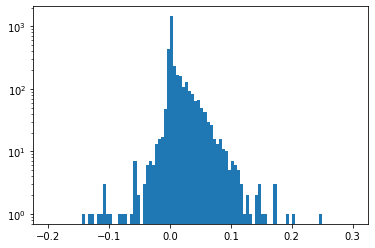

In [32]:
plt.hist(dLz_in_res, bins=100, range=(-0.2, 0.3))
plt.yscale('log')
plt.show()

In [146]:
def print_top_resonances(res, dLz, num=20):
    N, d, r = compute_2D_res_dLz(res, dLz)
    key_sort = np.flip(np.argsort(np.abs(d)))
    
    print(r.shape)
    
    print('total dLz=', np.sum(dLz).round(3))
    print('total dLz from resonances=', np.sum(d).round(3))
    
    for i in range(num):
        print(r[key_sort[i]], '\t', d[key_sort[i]].round(3), N[key_sort[i]])
    
    for i in range(len(r)):
        if r[i][0] == 0 and r[i][1] == 2:
            print('CR: ', r[i], '\t', d[i].round(3), N[i])

In [125]:
snap[15]

300

In [147]:
print_top_resonances(Omega_N3[:,25,3:], Omega_N3[:,25,-1])

(225, 2)
total dLz= 84.544
total dLz from resonances= 77.386
[0. 2.] 	 1.685 35837.0
[0. 1.] 	 1.101 35090.0
[-2.  5.] 	 1.061 28411.0
[-1.  0.] 	 1.06 26778.0
[1. 2.] 	 0.986 40941.0
[ 2. -1.] 	 0.957 43671.0
[-2.  0.] 	 0.939 19252.0
[0. 3.] 	 0.882 36617.0
[3. 2.] 	 0.818 45374.0
[-1. -1.] 	 0.808 26489.0
[-1.  1.] 	 0.8 28077.0
[-1.  2.] 	 0.726 28196.0
[4. 0.] 	 0.722 44586.0
[1. 1.] 	 0.714 42162.0
[2. 7.] 	 0.711 77832.0
[-5. -7.] 	 0.634 37596.0
[2. 3.] 	 0.622 41671.0
[0. 4.] 	 0.621 33953.0
[ 1. -6.] 	 0.614 33765.0
[3. 3.] 	 0.608 45631.0
CR:  [0. 2.] 	 1.685 35837.0


In [148]:
print_top_resonances(Omega_S3[:,15,3:], Omega_S3[:,15,-1])

(225, 2)
total dLz= 24.856
total dLz from resonances= 23.753
[7. 7.] 	 0.335 134444.0
[1. 7.] 	 0.283 48982.0
[ 2. -7.] 	 0.274 67695.0
[1. 3.] 	 0.262 39759.0
[2. 3.] 	 0.256 41496.0
[-4.  7.] 	 0.241 63924.0
[ 2. -6.] 	 0.241 41201.0
[ 0. -1.] 	 0.239 32994.0
[2. 6.] 	 0.239 44913.0
[-5.  7.] 	 0.238 40360.0
[-1.  6.] 	 0.237 34527.0
[3. 6.] 	 0.234 49054.0
[5. 0.] 	 0.233 46090.0
[6. 7.] 	 0.224 52846.0
[-1.  7.] 	 0.217 51879.0
[ 7. -4.] 	 0.215 45987.0
[7. 4.] 	 0.215 42596.0
[ 7. -6.] 	 0.207 42421.0
[ 7. -7.] 	 0.201 161459.0
[-1. -7.] 	 0.201 40409.0
CR:  [0. 2.] 	 -0.04 34518.0


In [149]:
print_top_resonances(Omega_S3[:,5,3:], Omega_S3[:,5,-1])

(225, 2)
total dLz= 41.381
total dLz from resonances= 40.447
[1. 7.] 	 0.42 22996.0
[ 1. -1.] 	 0.404 13095.0
[-5.  7.] 	 0.399 20073.0
[ 2. -7.] 	 0.392 24719.0
[ 1. -7.] 	 0.384 21942.0
[1. 5.] 	 0.376 15066.0
[-5. -7.] 	 0.374 16422.0
[ 0. -3.] 	 0.367 14249.0
[2. 6.] 	 0.361 17280.0
[2. 7.] 	 0.352 24611.0
[1. 4.] 	 0.35 13573.0
[ 1. -6.] 	 0.341 17131.0
[3. 4.] 	 0.334 13250.0
[2. 4.] 	 0.328 13665.0
[5. 0.] 	 0.322 12222.0
[ 2. -6.] 	 0.319 16793.0
[-1. -1.] 	 0.317 13792.0
[2. 5.] 	 0.316 14945.0
[7. 7.] 	 0.307 17477.0
[ 3. -3.] 	 0.306 13282.0
CR:  [0. 2.] 	 0.075 13214.0


In [34]:
for i in range(20):
    print(i, snap[i])

0 0
1 50
2 100
3 150
4 200
5 250
6 300
7 350
8 400
9 450
10 500
11 550
12 600
13 650
14 700
15 750
16 800
17 850
18 900
19 950


In [42]:
@njit
def count_occ_single_res(res, dLz, lR, lphi, lz, lRmin=-5, lRmax=5, lphimin=-5, lphimax=5, lzmin=-5, lzmax=5):
    lRlist = np.arange(lRmin, lRmax+1)
    lphilist = np.arange(lphimin, lphimax+1)
    lzlist = np.arange(lzmin, lzmax+1)
    
    Nres = len(lRlist)
    
    res_list = np.zeros((Nres**3, 3))
    
    for i in range(len(lRlist)):
        for j in range(len(lphilist)):
            for k in range(len(lzlist)):
                res_list[RES_IDX(i, j, k, Nres)][0] = lRlist[i]
                res_list[RES_IDX(i, j, k, Nres)][1] = lphilist[j]
                res_list[RES_IDX(i, j, k, Nres)][2] = lzlist[k]
    
    
    
    Npart = res.shape[0]
    Nsnap = res.shape[1]
    print(Npart, Nsnap)
    
    N_in_res = np.zeros(Nsnap)
    dLz_of_res = np.zeros(Nsnap)
    
    for j in range(Nsnap):
        for i in range(Npart):
            if res[i][j][0] == np.nan:
                continue
            
            if res[i][j][0] == lR:
                if res[i][j][1] == lphi:
                    if res[i][j][2] == lz:
                        N_in_res[j] += 1
                        dLz_of_res[j] += dLz[i][j]
    
    return N_in_res, dLz_of_res

3168480 32


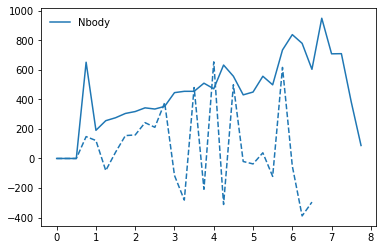

In [99]:
N, dLz = count_occ_single_res(Omega_N4[:,:,3:], Omega_N4[:,:,-1], 0, 1, 1)

l = plt.plot(snap/200., N, label='Nbody')
plt.plot(snap/200., dLz * 500, c=l[0].get_color(), ls='dashed')
# plt.plot(snap/200., N_ln555, c=l[0].get_color(), ls='dashed')
# l = plt.plot(snap/200., S_lp555, label='SMUGGLE')
# plt.plot(snap/200., S_ln555, c=l[0].get_color(), ls='dashed')
plt.legend(frameon=False)

plt.show()

3168480 32


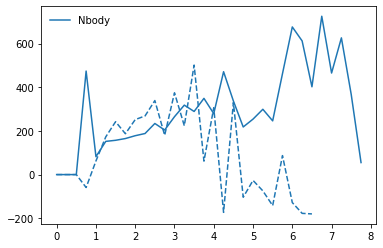

In [101]:
N, dLz = count_occ_single_res(Omega_N4[:,:,3:], Omega_N4[:,:,-1], -2, 5, 0)

l = plt.plot(snap/200., N, label='Nbody')
plt.plot(snap/200., dLz * 500, c=l[0].get_color(), ls='dashed')
# plt.plot(snap/200., N_ln555, c=l[0].get_color(), ls='dashed')
# l = plt.plot(snap/200., S_lp555, label='SMUGGLE')
# plt.plot(snap/200., S_ln555, c=l[0].get_color(), ls='dashed')
plt.legend(frameon=False)

plt.show()

In [75]:
N_CR = count_occ_single_res(Omega_N4[:,:,3:], 0, 2, 0)
N_aCR = count_occ_single_res(Omega_N4[:,:,3:], 0, -2, 0)

# S_CR = count_occ_single_res(Omega_S4[:,:,3:], 0, 2, 0)
# S_aCR = count_occ_single_res(Omega_S4[:,:,3:], 0, -2, 0)


3168480 32
3168480 32


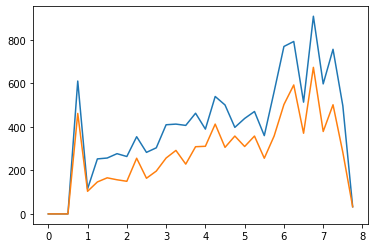

In [78]:
plt.plot(snap/200., N_CR)
plt.plot(snap/200., N_aCR)

plt.show()

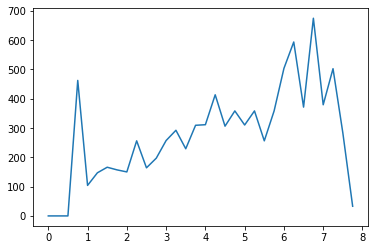

In [77]:
plt.plot(snap/200., N_aCR)
# plt.plot(snap/200., S_aCR)

plt.show()

In [44]:
@njit
def count_occ_lphi_pos_neg(res, lRmin=-5, lRmax=5, lphimin=-5, lphimax=5, lzmin=-5, lzmax=5):
    lRlist = np.arange(lRmin, lRmax+1)
    lphilist = np.arange(lphimin, lphimax+1)
    lzlist = np.arange(lzmin, lzmax+1)
    
    Nres = len(lRlist)
    
    res_list = np.zeros((Nres**3, 3))
    
    for i in range(len(lRlist)):
        for j in range(len(lphilist)):
            for k in range(len(lzlist)):
                res_list[RES_IDX(i, j, k, Nres)][0] = lRlist[i]
                res_list[RES_IDX(i, j, k, Nres)][1] = lphilist[j]
                res_list[RES_IDX(i, j, k, Nres)][2] = lzlist[k]
    
    
    
    Npart = res.shape[0]
    Nsnap = res.shape[1]
    print(Npart, Nsnap)
    
    N_in_res = np.zeros(Nsnap)
    N_lphi_pos = np.zeros(Nsnap)
    N_lphi_neg = np.zeros(Nsnap)
    N_lphi_zero = np.zeros(Nsnap)
    
    for j in range(Nsnap):
        for i in range(Npart):
            if res[i][j][0] == np.nan:
                continue
            
            if res[i][j][1] > 0.0:
                N_lphi_pos[j] += 1
                continue
            if res[i][j][1] < 0.0:
                N_lphi_neg[j] += 1
                continue
            N_lphi_zero[j] += 1
    
    return N_lphi_pos, N_lphi_neg, N_lphi_zero

In [45]:
Np, Nn, Nz = count_occ_lphi_pos_neg(Omega_N3[:,:,3:])
Sp, Sn, Sz = count_occ_lphi_pos_neg(Omega_S3[:,:,3:])

25347840 80
25347840 80


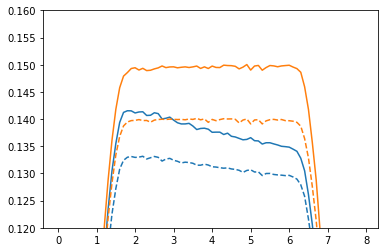

In [50]:
l = plt.plot(snap/200., Np/len(Omega_N3))
plt.plot(snap/200., Nn/len(Omega_N3), c=l[0].get_color(), ls='dashed')
# plt.plot(snap/200., Nz, c=l[0].get_color(), ls='dotted')

l = plt.plot(snap/200., Sp/len(Omega_S3))
plt.plot(snap/200., Sn/len(Omega_S3), c=l[0].get_color(), ls='dashed')

plt.ylim(0.12, 0.16)

plt.show()

In [51]:
Np

array([      0.,       0.,       0.,       0.,       0.,       0.,
             0.,       0., 1883655., 2178231., 2432494., 2678987.,
       2914223., 3129195., 3306996., 3434751., 3533245., 3579789.,
       3587505., 3587104., 3577213., 3581788., 3582773., 3565574.,
       3566471., 3578177., 3574151., 3549242., 3552448., 3557804.,
       3543921., 3531551., 3526038., 3526148., 3528731., 3516406.,
       3499880., 3504885., 3506149., 3501487., 3487144., 3487772.,
       3487760., 3476729., 3482981., 3468414., 3465303., 3458657.,
       3452075., 3453936., 3462019., 3447895., 3446834., 3432260.,
       3438301., 3438301., 3432872., 3427975., 3421795., 3420133.,
       3417862., 3408486., 3398407., 3366198., 3307781., 3196426.,
       3057235., 2879913., 2678276., 2451070., 2221063., 1971892.,
       1704986., 1447230., 1165385.,  876681.,  609408.,  366905.,
        175797.,   54892.])

In [76]:
Nn

array([8951206., 8951206., 8951206., 8951206., 8951206., 8951206.,
       8951206., 8951206., 8951206., 8951206., 8951206., 8951206.,
       8951206., 8951206., 8951206., 8951206., 8951206., 8951206.,
       8951206., 8951206., 8951206., 8951206., 8951206., 8951206.,
       8951206., 8951206., 8951206., 8951206., 8951206., 8951206.,
       8951206., 8951206.])

In [54]:
Ntot_in_res_N = []
Ntot_in_res_S = []
for i in range(len(snap)):
    N = len(np.where(np.logical_not(np.isnan(Omega_N3[:,i,3])))[0])
    Ntot_in_res_N.append(N)
    
    N = len(np.where(np.logical_not(np.isnan(Omega_S3[:,i,3])))[0])
    Ntot_in_res_S.append(N)

KeyboardInterrupt: 

In [ ]:
plt.plot(snap/200., Ntot_in_res_N)
plt.plot(snap/200., Ntot_in_res_S)
plt.show()

96.43735750980541
0.0


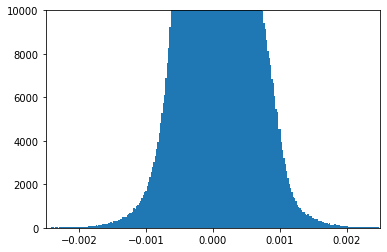

In [58]:
from scipy.stats import norm

dLz = Omega_N3[:,10,-1]

print(np.sum(dLz))
print(np.sum(dLz[np.logical_and(np.abs(dLz)>0.005, np.abs(dLz)<0.01)]))
plt.hist(dLz, bins=np.linspace(-0.01, 0.01, 1000))

# mu, std = norm.fit(dLz)
# x = np.linspace(-0.05, 0.05, 10000)
# y = norm.pdf(x, 0, std)
# plt.plot(x, y)

plt.ylim(0, 10000)
plt.xlim(-0.0025, 0.0025)

plt.show()

400
77.8208995925516
3.070119568079631e-06 0.00012516319511591043
-2.942465700965912
2.951846071147684
77.81151922236985


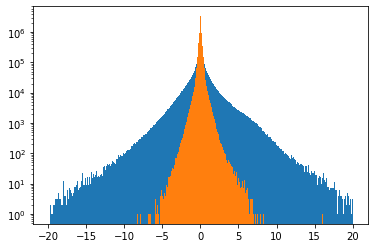

In [117]:
from scipy.stats import norm

this_snap = 20
print(snap[this_snap])

Omega = Omega_N3
dLz = Omega[:,this_snap,-1]

in_res = np.logical_not(np.isnan(Omega[:,this_snap,0]))
not_in_res = np.isnan(Omega[:,this_snap,0])

print(np.sum(dLz))


mu, std = norm.fit(dLz)
print(mu, std)
print(np.sum(dLz[np.logical_and(np.abs(dLz)>std, np.abs(dLz)<3.*std)]))
print(np.sum(dLz[np.abs(dLz) < std]))
print(np.sum(dLz[np.abs(dLz) > 3.*std]))

plt.hist(dLz[in_res]/std, bins=np.linspace(-20, 20, 1000))
plt.hist(dLz[not_in_res]/std, bins=np.linspace(-20, 20, 1000))

# x = np.linspace(-0.05, 0.05, 10000)
# y = norm.pdf(x, 0, std)
# plt.plot(x, y)

# plt.ylim(0, 100000)
# plt.xlim(-0.0025, 0.0025)
plt.yscale('log')

plt.show()

200
21.777629684772915
8.591512998651134e-07 9.626505317139963e-05
12.16366212805694
2.735999905016051
6.877967651699975


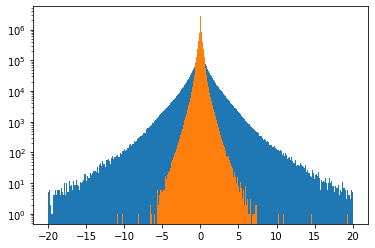

In [116]:
from scipy.stats import norm

this_snap = 10
print(snap[this_snap])

Omega = Omega_S3
dLz = Omega[:,this_snap,-1]

in_res = np.logical_not(np.isnan(Omega[:,this_snap,0]))
not_in_res = np.isnan(Omega[:,this_snap,0])

print(np.sum(dLz))


mu, std = norm.fit(dLz)
print(mu, std)
print(np.sum(dLz[np.logical_and(np.abs(dLz)>std, np.abs(dLz)<3.*std)]))
print(np.sum(dLz[np.abs(dLz) < std]))
print(np.sum(dLz[np.abs(dLz) > 3.*std]))

plt.hist(dLz[in_res]/std, bins=np.linspace(-20, 20, 1000))
plt.hist(dLz[not_in_res]/std, bins=np.linspace(-20, 20, 1000))

# x = np.linspace(-0.05, 0.05, 10000)
# y = norm.pdf(x, 0, std)
# plt.plot(x, y)

# plt.ylim(0, 100000)
# plt.xlim(-0.0025, 0.0025)
plt.yscale('log')

plt.show()

500
36.28619541264606
3736
num hi tol =  347
[-0.0006755   0.00055361         nan         nan         nan  0.00071647
         nan -0.00086545         nan         nan]


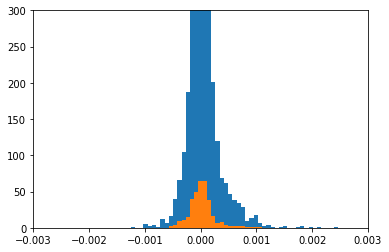

In [115]:
from scipy.stats import norm

this_snap = 25
print(snap[this_snap])

Omega = Omega_N3
Op = ps_N[this_snap]
dLz = Omega[:,this_snap,-1]

print(Op)

lR = -1
lphi = 2
lz = 5

Rbool = Omega[:,10,3] == lR
phibool = Omega[:,10,4] == lphi
zbool = Omega[:,10,5] == lz

at_res = np.logical_and(np.logical_and(Rbool, phibool), zbool)
print(len(np.where(at_res)[0]))

tol = (Omega[:,this_snap,0]*Omega[:,this_snap,3] + \
       Omega[:,this_snap,1]*Omega[:,this_snap,4] + \
       Omega[:,this_snap,2]*Omega[:,this_snap,5])/(2.*Op) - 1.0

hi_tol = np.logical_and(at_res, np.abs(tol) < 0.0001)
print('num hi tol = ', len(np.where(hi_tol)[0]))

print(tol[:10])

# print(np.sum(dLz))
# print(np.sum(dLz[np.logical_and(np.abs(dLz)>0.005, np.abs(dLz)<0.01)]))
plt.hist(dLz[at_res], bins=np.linspace(-0.003, 0.003, 80))
plt.hist(dLz[hi_tol], bins=np.linspace(-0.003, 0.003, 80))

mu, std = norm.fit(dLz)
x = np.linspace(-0.05, 0.05, 10000)
y = norm.pdf(x, 0, std)
# plt.plot(x, y)

plt.ylim(0, 300)
plt.xlim(-0.003, 0.003)

plt.show()

In [115]:
from scipy.stats import norm


In [87]:
print(mu, std)

8.591512998651134e-07 9.626505317139963e-05


In [16]:
@njit
def un_asymmetrize(dLz):
    dLz_pos = dLz[dLz >= 0]
    dLz_neg = dLz[dLz < 0]
    
    dLz_pos = np.sort(dLz_pos)
    dLz_neg = -np.sort(-dLz_neg)
    
    tot_dLz = 0.0
    Npos = dLz_pos.shape[0]
    Nneg = dLz_neg.shape[0]
    
    i = j = 0
    while i < Npos and j < Nneg:
        if tot_dLz >= 0:
            tot_dLz += dLz_neg[j]
            j += 1
        else:
            tot_dLz += dLz_pos[i]
            i += 1
    
    if i==Npos:
        # this resonance is negative
        return dLz_neg[j:]
    else:
        return dLz_pos[i:]
    

500
35837
1748
1.6853175053226184
0.0023846327906701078


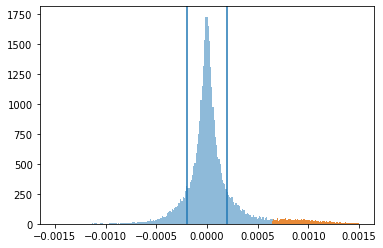

In [149]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

this_snap = 25

Omega = Omega_N3
dLz = Omega[:,this_snap,-1]

lR = 0
lphi = 2
lz = 0

xrng = (-0.0015, 0.0015)

print(snap[this_snap])
Rbool = Omega[:,this_snap,3] == lR
phibool = Omega[:,this_snap,4] == lphi
# zbool = Omega[:,this_snap,5] == lz
# totbool = np.logical_and(np.logical_and(Rbool, phibool), zbool)
totbool = np.logical_and(Rbool, phibool)

print(len(np.where(totbool)[0]))

# model = GaussianMixture(10).fit(dLz[totbool].reshape((-1, 1)))
# x = np.linspace(xrng[0], xrng[1], 10000)
# resp = model.predict_proba(x.reshape((-1, 1)))

# mu, std = norm.fit(dLz[totbool])

p = resp.cumsum(1).T
# plt.fill_between(x, 0, p[0], color='gray', alpha=0.3)
# plt.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
# plt.fill_between(x, p[1], 1, color='gray', alpha=0.7)

plt.hist(dLz[totbool], bins=np.linspace(xrng[0], xrng[1], 256), alpha=0.5)

t = un_asymmetrize(dLz[totbool])
print(len(t))
plt.hist(t, bins=np.linspace(xrng[0], xrng[1], 256), alpha=0.8)

plt.axvline(mu + 1.5*std)
plt.axvline(mu - 1.5*std)
print(np.sum(dLz[totbool]))
print(np.max(dLz[totbool]))
plt.show()

500
35837
-0.6524766714770792
0.0023846327906701078


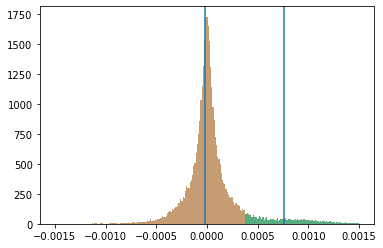

In [143]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from sklearn.cluster import KMeans

this_snap = 25

Omega = Omega_N3
dLz = Omega[:,this_snap,-1]

lR = 0
lphi = 2
lz = 0

xrng = (-0.0015, 0.0015)

print(snap[this_snap])
Rbool = Omega[:,this_snap,3] == lR
phibool = Omega[:,this_snap,4] == lphi
# zbool = Omega[:,this_snap,5] == lz
# totbool = np.logical_and(np.logical_and(Rbool, phibool), zbool)
totbool = np.logical_and(Rbool, phibool)

print(len(np.where(totbool)[0]))

ans = KMeans(2).fit(dLz[totbool].reshape(-1, 1))

mu, std = norm.fit(dLz)

p = resp.cumsum(1).T
# plt.fill_between(x, 0, p[0], color='gray', alpha=0.3)
# plt.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
# plt.fill_between(x, p[1], 1, color='gray', alpha=0.7)


plt.hist(dLz[totbool], bins=np.linspace(xrng[0], xrng[1], 256), alpha=0.5)
plt.hist(dLz[totbool][ans.labels_==0], bins=np.linspace(xrng[0], xrng[1], 256), alpha=0.5)
plt.hist(dLz[totbool][ans.labels_==1], bins=np.linspace(xrng[0], xrng[1], 256), alpha=0.5)
# plt.axvline(mu + 3.*std)
# plt.axvline(mu - 3.*std)
plt.axvline(ans.cluster_centers_[0])
plt.axvline(ans.cluster_centers_[1])
print(np.sum(dLz[totbool][ans.labels_==0]))
print(np.max(dLz[totbool][ans.labels_==1]))
plt.show()

In [138]:
ans.labels_

array([0, 1, 0, ..., 0, 1, 0], dtype=int32)

0
1
2


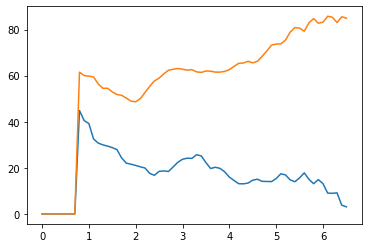

In [97]:
Omega = Omega_N3

print(0)
in_res = np.logical_not(np.isnan(Omega[:,:,3]))
in_res_pro = np.logical_and(in_res, Omega[:,:,1] > 0)
print(1)
in_res_ret = np.logical_and(in_res, Omega[:,:,1] < 0)
print(2)

dLz_pro = []
dLz_ret = []
for i in range(len(snap)):
    dLz_pro.append(np.sum(Omega[:,i,-1][in_res_pro[:,i]]))
    dLz_ret.append(np.sum(Omega[:,i,-1][in_res_ret[:,i]]))

dLz_pro = np.array(dLz_pro)
dLz_ret = np.array(dLz_ret)

# dLz_pro = np.sum(Omega[:,:,-1][in_res_pro], axis=0)
# print(3)
# dLz_ret = np.sum(Omega[:,:,-1][in_res_ret], axis=0)

plt.plot(snap/200., dLz_pro, label='prograde')
plt.plot(snap/200., dLz_ret, label='retrograde')
plt.show()

0
1
2


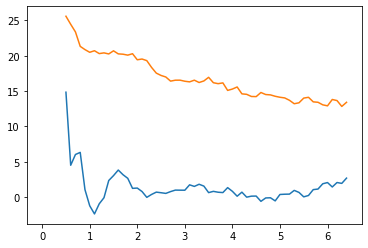

In [98]:
Omega = Omega_S3

print(0)
in_res = np.logical_not(np.isnan(Omega[:,:,3]))
in_res_pro = np.logical_and(in_res, Omega[:,:,1] > 0)
print(1)
in_res_ret = np.logical_and(in_res, Omega[:,:,1] < 0)
print(2)

dLz_pro = []
dLz_ret = []
for i in range(len(snap)):
    dLz_pro.append(np.sum(Omega[:,i,-1][in_res_pro[:,i]]))
    dLz_ret.append(np.sum(Omega[:,i,-1][in_res_ret[:,i]]))

dLz_pro = np.array(dLz_pro)
dLz_ret = np.array(dLz_ret)

# dLz_pro = np.sum(Omega[:,:,-1][in_res_pro], axis=0)
# print(3)
# dLz_ret = np.sum(Omega[:,:,-1][in_res_ret], axis=0)

plt.plot(snap/200., dLz_pro, label='prograde')
plt.plot(snap/200., dLz_ret, label='retrograde')
plt.show()

In [2]:
ps = h5.File('/n/home01/abeane/starbar/plots/phase_space/data/Nbody-lvl4/phase_space_Nbody-lvl4.0.hdf5', mode='r')

In [3]:
ps_pos = ps['PartType1/Coordinates'][:]
ps_vel = ps['PartType1/Velocities'][:]
# ps_Lz = sn0.MassTable[1].value * np.cross(ps_pos, ps_vel)[:,:,2]

In [22]:
half_width = 100
delta = 200
Lz = np.cross(ps_pos, ps_vel)[:,:,2]
dLz = np.zeros(np.shape(Lz))
Nsnap = Lz.shape[0]
Npart = Lz.shape[1]
print(Lz.shape)
for i in tqdm(range(Nsnap)):
    if i < half_width or i >= Nsnap - half_width - delta:
        dLz[i] = np.full(Npart, np.nan)
    else:
        mean_Lz_1 = np.mean(Lz[i+delta-half_width:i+delta+half_width], axis=0)
        mean_Lz_0 = np.mean(Lz[i-half_width:i+half_width], axis=0)
        dLz[i] = mean_Lz_1 - mean_Lz_0
    

(1601, 6189)


A Jupyter Widget

200 400
0 200
201 401
1 201
202 402
2 202
203 403
3 203
204 404
4 204
205 405
5 205
206 406
6 206
207 407
7 207
208 408
8 208
209 409
9 209
210 410
10 210
211 411
11 211
212 412
12 212
213 413
13 213
214 414
14 214
215 415
15 215
216 416
16 216
217 417
17 217
218 418
18 218
219 419
19 219
220 420
20 220
221 421
21 221
222 422
22 222
223 423
23 223
224 424
24 224
225 425
25 225
226 426
26 226
227 427
27 227
228 428
28 228
229 429
29 229
230 430
30 230
231 431
31 231
232 432
32 232
233 433
33 233
234 434
34 234
235 435
35 235
236 436
36 236
237 437
37 237
238 438
38 238
239 439
39 239
240 440
40 240
241 441
41 241
242 442
42 242
243 443
43 243
244 444
44 244
245 445
45 245
246 446
46 246
247 447
47 247
248 448
48 248
249 449
49 249
250 450
50 250
251 451
51 251
252 452
52 252
253 453
53 253
254 454
54 254
255 455
55 255
256 456
56 256
257 457
57 257
258 458
58 258
259 459
59 259
260 460
60 260
261 461
61 261
262 462
62 262
263 463
63 263
264 464
64 264
265 465
65 265
266 466
66 266
267 4

742 942
542 742
743 943
543 743
744 944
544 744
745 945
545 745
746 946
546 746
747 947
547 747
748 948
548 748
749 949
549 749
750 950
550 750
751 951
551 751
752 952
552 752
753 953
553 753
754 954
554 754
755 955
555 755
756 956
556 756
757 957
557 757
758 958
558 758
759 959
559 759
760 960
560 760
761 961
561 761
762 962
562 762
763 963
563 763
764 964
564 764
765 965
565 765
766 966
566 766
767 967
567 767
768 968
568 768
769 969
569 769
770 970
570 770
771 971
571 771
772 972
572 772
773 973
573 773
774 974
574 774
775 975
575 775
776 976
576 776
777 977
577 777
778 978
578 778
779 979
579 779
780 980
580 780
781 981
581 781
782 982
582 782
783 983
583 783
784 984
584 784
785 985
585 785
786 986
586 786
787 987
587 787
788 988
588 788
789 989
589 789
790 990
590 790
791 991
591 791
792 992
592 792
793 993
593 793
794 994
594 794
795 995
595 795
796 996
596 796
797 997
597 797
798 998
598 798
799 999
599 799
800 1000
600 800
801 1001
601 801
802 1002
602 802
803 1003
603 803
804 

1225 1425
1025 1225
1226 1426
1026 1226
1227 1427
1027 1227
1228 1428
1028 1228
1229 1429
1029 1229
1230 1430
1030 1230
1231 1431
1031 1231
1232 1432
1032 1232
1233 1433
1033 1233
1234 1434
1034 1234
1235 1435
1035 1235
1236 1436
1036 1236
1237 1437
1037 1237
1238 1438
1038 1238
1239 1439
1039 1239
1240 1440
1040 1240
1241 1441
1041 1241
1242 1442
1042 1242
1243 1443
1043 1243
1244 1444
1044 1244
1245 1445
1045 1245
1246 1446
1046 1246
1247 1447
1047 1247
1248 1448
1048 1248
1249 1449
1049 1249
1250 1450
1050 1250
1251 1451
1051 1251
1252 1452
1052 1252
1253 1453
1053 1253
1254 1454
1054 1254
1255 1455
1055 1255
1256 1456
1056 1256
1257 1457
1057 1257
1258 1458
1058 1258
1259 1459
1059 1259
1260 1460
1060 1260
1261 1461
1061 1261
1262 1462
1062 1262
1263 1463
1063 1263
1264 1464
1064 1264
1265 1465
1065 1265
1266 1466
1066 1266
1267 1467
1067 1267
1268 1468
1068 1268
1269 1469
1069 1269
1270 1470
1070 1270
1271 1471
1071 1271
1272 1472
1072 1272
1273 1473
1073 1273
1274 1474
1074 1274


In [4]:
@njit
def loop_dLz(pos, vel, mass, half_width=100, delta=200):
    Lz = pos[:,:,0] * vel[:,:,1] - pos[:,:,1] * vel[:,:,0]
    Lz *= mass

    Nsnap = Lz.shape[0]
    Npart = Lz.shape[1]

    dLz = np.zeros(Lz.shape)

    for i in range(Nsnap):
        if i <= half_width or i >= Nsnap - half_width - delta - 1:
            dLz[i] = np.full(Npart, np.nan)
        else:
            for j in range(Npart):
                mean_Lz_1 = np.mean(Lz[i+delta-half_width:i+delta+half_width][j])
                mean_Lz_0 = np.mean(Lz[i-half_width:i+half_width][j])
                dLz[i][j] = mean_Lz_1 - mean_Lz_0

    return dLz


In [ ]:
dLz = loop_dLz(ps_pos, ps_vel, 1.0)

In [167]:
np.where(totbool)[0][:20]

array([  273,   387,  1838,  5662,  8736, 12220, 16434, 23806, 26122,
       30725, 34518, 40686, 47039, 56492, 56891, 58933, 63969, 69628,
       74589, 84817])

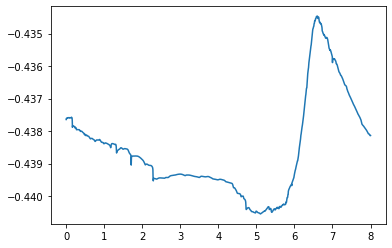

In [182]:
plt.plot(np.arange(len(ps_Lz[:,1021]))/200., ps_Lz[:,24])
plt.show()

In [174]:
not_in_res = np.isnan(Omega_N4[:,10,3])
np.where(not_in_res)[0][:20]

array([ 2,  3,  4,  6,  8,  9, 10, 11, 13, 14, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26])

In [14]:
def compute_2D_res_occ_sigma(res, dLz, sigma=2., lRmin=-7, lRmax=7, lphimin=-7, lphimax=7, lzmin=-7, lzmax=7):
    lRlist = np.arange(lRmin, lRmax+1)
    lphilist = np.arange(lphimin, lphimax+1)
    
    Nres = len(lRlist)
    
    res_list = np.zeros((Nres**2, 2))
    
    for i in range(len(lRlist)):
        for j in range(len(lphilist)):
            res_list[RES_IDX_2D(i, j, Nres)][0] = lRlist[i]
            res_list[RES_IDX_2D(i, j, Nres)][1] = lphilist[j]
    
    Npart = res.shape[0]
    Nsnap = res.shape[1]
#     print(Npart, Nsnap)
    
    N_in_res = np.zeros(Nres**2)
    dLz_in_res = np.zeros(Nres**2)
    dLz_of_cont = np.zeros(Nres**2)
    
#     for j in tqdm(range(Nsnap)):
    for ii in tqdm(range(len(lRlist))):
        for jj in range(len(lphilist)):
            Rbool = res[:,0] == lRlist[ii]
            phibool = res[:,1] == lphilist[jj]
            totbool = np.logical_and(Rbool, phibool)
                
            N_in_res[RES_IDX_2D(ii, jj, Nres)] += len(un_asymmetrize(dLz[totbool]))
#             dLz_in_res[RES_IDX_2D(ii, jj, Nres)] += np.sum(dLz[totbool][in_res])
#             dLz_of_cont[RES_IDX_2D(ii, jj, Nres)] += np.sum(dLz[totbool][not_in_res])
    
    return N_in_res, dLz_in_res, dLz_of_cont, res_list

In [17]:
print(snap[5])
N_S3_5, dLz_res_S3_5, dLz_cont_S3_5, res_list = compute_2D_res_occ_sigma(Omega_S3[:,5,3:], Omega_S3[:,5,-1])

100


A Jupyter Widget

In [18]:
print(snap[15])
N_S3_15, dLz_res_S3_15, dLz_cont_S3_15, res_list = compute_2D_res_occ_sigma(Omega_S3[:,15,3:], Omega_S3[:,15,-1])

300


A Jupyter Widget

In [22]:
print(snap[25])
N_S3_25, dLz_res_S3_25, dLz_cont_S3_25, res_list = compute_2D_res_occ_sigma(Omega_S3[:,25,3:], Omega_S3[:,25,-1])

500


A Jupyter Widget

In [23]:
print(np.sum(N_S3_5), np.sum(N_S3_15), np.sum(N_S3_25))

46159.0 33294.0 29141.0


In [20]:
print(snap[25])
N_N3_25, dLz_res_N3_25, dLz_cont_N3_25, res_list = compute_2D_res_occ_sigma(Omega_N3[:,25,3:], Omega_N3[:,25,-1])

500


A Jupyter Widget

In [29]:
k = np.flip(np.argsort(N_N3_25))
for i in range(10):
    print(res_list[k[i]], N_N3_25[k[i]])

[0. 2.] 1748.0
[0. 1.] 1208.0
[-1.  0.] 1059.0
[1. 2.] 1019.0
[-2.  5.] 1008.0
[-2.  0.] 931.0
[ 2. -1.] 903.0
[0. 3.] 887.0
[-1. -1.] 839.0
[1. 1.] 809.0


In [31]:
k = np.flip(np.argsort(N_S3_25))
for i in range(10):
    print(res_list[k[i]], N_S3_25[k[i]])

for i in range(len(k)):
    if res_list[k[i]][0] == 0 and res_list[k[i]][1] == 2:
        print('CR', N_S3_25[k[i]])

[-5. -7.] 801.0
[7. 7.] 599.0
[-5.  7.] 562.0
[-4.  7.] 555.0
[-4. -7.] 485.0
[-2. -7.] 469.0
[-3. -7.] 444.0
[ 1. -6.] 392.0
[-5.  6.] 373.0
[ 2. -1.] 356.0
CR 158.0


In [32]:
def compute_2D_res_occ_sigma_single_res(res, dLz, lR, lphi):
    Npart = res.shape[0]
    Nsnap = res.shape[1]
    
    N_in_res = np.zeros(Nsnap)
    dLz_in_res = np.zeros(Nsnap)
    
#     for j in tqdm(range(Nsnap)):
    for i in tqdm(range(Nsnap)):
        Rbool = res[:,i,0] == lR
        phibool = res[:,i,1] == lphi
        totbool = np.logical_and(Rbool, phibool)
                
        N_in_res[i] += len(un_asymmetrize(dLz[totbool,i]))
        dLz_in_res[i] += np.sum(dLz[totbool,i])
    
    return N_in_res, dLz_in_res

In [33]:
N_N_CR, d_N_CR = compute_2D_res_occ_sigma_single_res(Omega_N3[:,:,3:], Omega_N3[:,:,-1], 0, 2)

A Jupyter Widget

In [34]:
N_S_CR, d_S_CR = compute_2D_res_occ_sigma_single_res(Omega_S3[:,:,3:], Omega_S3[:,:,-1], 0, 2)

A Jupyter Widget

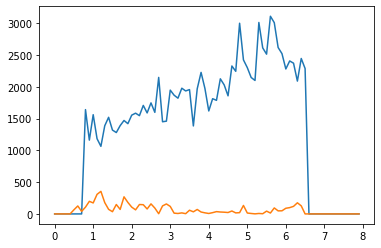

In [35]:
plt.plot(snap/200., N_N_CR)
plt.plot(snap/200., N_S_CR)

plt.show()

In [37]:
N_N_OLR, d_N_OLR = compute_2D_res_occ_sigma_single_res(Omega_N3[:,:,3:], Omega_N3[:,:,-1], 1, 2)
N_S_OLR, d_S_OLR = compute_2D_res_occ_sigma_single_res(Omega_S3[:,:,3:], Omega_S3[:,:,-1], 1, 2)

A Jupyter Widget

A Jupyter Widget

In [38]:
N_N_ILR, d_N_ILR = compute_2D_res_occ_sigma_single_res(Omega_N3[:,:,3:], Omega_N3[:,:,-1], -1, 2)
N_S_ILR, d_S_ILR = compute_2D_res_occ_sigma_single_res(Omega_S3[:,:,3:], Omega_S3[:,:,-1], -1, 2)

A Jupyter Widget

A Jupyter Widget

In [39]:
N_N_25, d_N_25 = compute_2D_res_occ_sigma_single_res(Omega_N3[:,:,3:], Omega_N3[:,:,-1], -2, 5)
N_S_25, d_S_25 = compute_2D_res_occ_sigma_single_res(Omega_S3[:,:,3:], Omega_S3[:,:,-1], -2, 5)

A Jupyter Widget

A Jupyter Widget

In [43]:
N_N_77, d_N_77 = compute_2D_res_occ_sigma_single_res(Omega_N3[:,:,3:], Omega_N3[:,:,-1], 7, 7)
N_S_77, d_S_77 = compute_2D_res_occ_sigma_single_res(Omega_S3[:,:,3:], Omega_S3[:,:,-1], 7, 7)

A Jupyter Widget

A Jupyter Widget

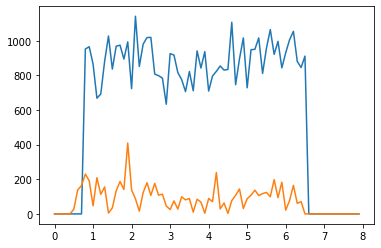

In [40]:
plt.plot(snap/200., N_N_OLR)
plt.plot(snap/200., N_S_OLR)

plt.show()

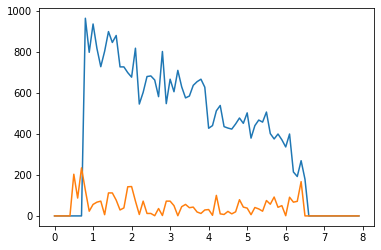

In [41]:
plt.plot(snap/200., N_N_ILR)
plt.plot(snap/200., N_S_ILR)

plt.show()

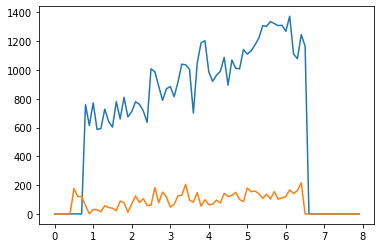

In [42]:
plt.plot(snap/200., N_N_25)
plt.plot(snap/200., N_S_25)

plt.show()

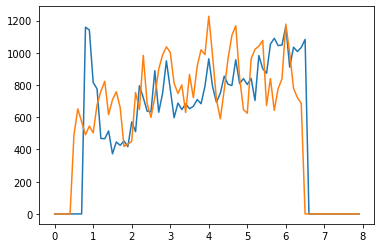

In [44]:
plt.plot(snap/200., N_N_77)
plt.plot(snap/200., N_S_77)

plt.show()

In [ ]:
print(1)